In [ ]:
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter, defaultdict
import pandas as pd
import pickle
import numpy as np
from shapely.geometry import Polygon, Point, LinearRing, box
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn import linear_model, decomposition
from sklearn.feature_extraction import DictVectorizer
%matplotlib notebook

In [ ]:
df_train = pd.read_pickle('df_train')
df_test = pd.read_pickle('df_test')
x_train_df_1 = pd.read_pickle('new_x_train_df')
x_test_df_1 = pd.read_pickle('new_x_test_df')
x_train_df = pd.read_pickle('x_train_df_2')
x_test_df = pd.read_pickle('x_test_df_2')

In [ ]:
x_train_df = x_train_df.sort_values('hash',ascending=True)
x_test_df = x_test_df.sort_values('hash',ascending=True)

In [ ]:
x_train_df = pd.merge(x_train_df, x_train_df_1, on='hash')
x_test_df = pd.merge(x_test_df, x_test_df_1, on='hash')

In [ ]:
print(x_train_df.shape, x_test_df.shape)

In [ ]:
min_x_entry = min(min(df_train.x_entry.describe()['min'], df_test.x_entry.describe()['min']),
                  df_train.x_exit.describe()['min'])
min_y_entry = min(min(df_train.y_entry.describe()['min'], df_test.y_entry.describe()['min']),
                  df_train.y_exit.describe()['min'])
max_x_entry = max(max(df_train.x_entry.describe()['max'], df_test.x_entry.describe()['max']),
                  df_train.x_exit.describe()['max'])
max_y_entry = max(max(df_train.y_entry.describe()['max'], df_test.y_entry.describe()['max']),
                  df_train.y_exit.describe()['max'])
print(min_x_entry, max_x_entry, min_y_entry, max_y_entry)

In [ ]:
def plot_map():
    rect_all = patches.Rectangle((3740998.35481912, -19042656.658487003), (3777099.2656833767 - 3740998.35481912),
                             (- 19382914.9809002 + 19042656.658487003),
                             linewidth=1,edgecolor='g',fill = False,hatch = '\\\\\\', label = 'city')
    city = plt.gca().add_patch(rect_all)
    rect_city = patches.Rectangle((3750901.5068, -19208905.6133), (3770901.5068 - 3750901.5068),
                             (- 19268905.6133 + 19208905.6133),
                             linewidth=1,edgecolor='r',fill = False,hatch = '//////', label = 'city center')
    city_center = plt.gca().add_patch(rect_city)
    plt.legend(handles=[city, city_center])
    plt.grid(True)
#     plt.xlim(min_x_entry, max_x_entry)
    plt.ylim(min_y_entry, max_y_entry)
    plt.xlim(3740000, 3780000)
    plt.ylim(-19000000, - 19400000)
    plt.show()

In [ ]:
def get_box(x,y):
    n1 = -1
    n2 = -1
    if(~np.isnan(x) and ~np.isnan(y)):
        if(x >= 3740000.0000000000 and x < 3745000.0000000000):
            n1 = 1
        elif(x >= 3745000.0000000000 and x < 3750000.0000000000):
            n1 = 2
        elif(x >= 3750000.0000000000 and x < 3755000.0000000000):
            n1 = 3
        elif(x >= 3755000.0000000000 and x < 3760000.0000000000):
            n1 = 4
        elif(x >= 3760000.0000000000 and x < 3765000.0000000000):
            n1 = 5
        elif(x >= 3765000.0000000000 and x < 3770000.0000000000):
            n1 = 6
        elif(x >= 3770000.0000000000 and x < 3775000.0000000000):
            n1 = 7
        else:
            n1 = 8

        if(y >= -19400000.0000000000 and y < -19350000.0000000000):
            n2 = 8
        elif(y >= -19350000.0000000000 and y < -19300000.0000000000):
            n2 = 7
        elif(y >= -19300000.0000000000 and y < -19250000.0000000000):
            n2 = 6
        elif(y >= -19250000.0000000000 and y < -19200000.0000000000):
            n2 = 5
        elif(y >= -19200000.0000000000 and y < -19150000.0000000000):
            n2 = 4
        elif(y >= -19150000.0000000000 and y < -19100000.0000000000):
            n2 = 3
        elif(y >= -19100000.0000000000 and y < -19050000.0000000000):
            n2 = 2
        else:
            n2 = 1
    
        return (n2-1)*8 + n1
    else:
        return 0

In [ ]:
df_test['distance'] = df_test.apply(lambda row: Point(row['x_entry'],row['y_entry']).
                                      distance(Point(row['x_exit'],row['y_exit'])) if ~np.isnan(row['x_exit'])
                                     else np.nan, axis=1)
df_test['velocity'] = df_test.apply(lambda row: (row['distance']/row['duration'])
                                      if (row['duration']!= 0.0 and ~np.isnan(row['x_exit'])) else 0.0, axis=1)
df_train['entry_box'] = df_train.apply(lambda row: get_box(row['x_entry'], row['y_entry']) , axis=1)
df_train['exit_box'] = df_train.apply(lambda row: get_box(row['x_exit'], row['y_exit']) , axis=1)
df_test['entry_box'] = df_test.apply(lambda row: get_box(row['x_entry'], row['y_entry']) , axis=1)
df_test['exit_box'] = df_test.apply(lambda row: get_box(row['x_exit'], row['y_exit']) , axis=1)

In [ ]:
df_train.to_pickle('df_train')
df_test.to_pickle('df_test')

In [ ]:
df = df_train.groupby('hash')
df_list = list(df)

In [ ]:
df_test_group = df_test.groupby('hash')
df_test_list = list(df_test_group)

In [ ]:
dataset = []
print(len(df_list))
for index, sample in enumerate(df_list):
    length = sample[1].shape[0]
    count = 0
    features = {}
    features['hash'] = sample[0]
    for index1, row in sample[1].iterrows():
        features['trajectory_id']  = row['trajectory_id']
        if(count < length - 1):
#             features['box_'+ str(row['entry_box'])]  = features.get('box_'+ str(row['entry_box']),0) + 1
#             features['box_' + str(row['exit_box'])]  = features.get('box_'+ str(row['exit_box']),0) + 1
            features['entry_box_'+ str(row['entry_box'])]  = features.get('entry_box_'+ str(row['entry_box']),0) + 1
            features['exit_box_' + str(row['exit_box'])]  = features.get('exit_box_'+ str(row['exit_box']),0) + 1
            features['duration_history']  = features.get('duration_history', 0) + row['duration']
            features['distance_history']  = features.get('distance_history', 0) + row['distance']
#             features['entry_time_'+ str(int(row['time_entry'] / np.timedelta64(1, 'h')))] = features.get('entry_time_'+ str(int(row['time_entry'] / np.timedelta64(1, 'h'))),0) + 1
#             features['exit_time_'+ str(int(row['time_exit'] / np.timedelta64(1, 'h')))] = features.get('exit_time_'+ str(int(row['time_entry'] / np.timedelta64(1, 'h'))),0) + 1
#             features['box_duration_'+ str(row['entry_box'])]  = features.get('box_duration_'+ str(row['entry_box']),0) + row['duration']
#             features['box_distance_'+ str(row['entry_box'])]  = features.get('box_distance'+ str(row['entry_box']),0) + row['distance']
            
        else:
            features['l_entry']  = row['entry_box']
#             features['l_exit']  = row['exit_box']
            features['x_entry'] = row['x_entry']
            features['y_entry'] = row['y_entry']
            features['duration'] = row['duration']
            features['city_distance'] = row['city_distance']
            features['hour'] = row['hour']
            features['label'] = row['label']
        count = count + 1
    features['duration_history'] = features.get('duration_history', 0) / length
    features['distance_history'] = features.get('distance_history', 0) / length
#     comp = new_train[new_train['hash'] == sample[0]]
#     features['avg_azimuth'] = comp.avg_azimuth.mean()
#     features['box_area'] = comp.box_area.mean()
#     for index2, row in comp.iterrows():
#         features['avg_trip_duration_'+ str(row['entry_hour'])]  = features.get('avg_trip_duration_'+ str(row['entry_hour']),0) + row['avg_trip_duration']
#         features['avg_trip_length_'+ str(row['entry_hour'])]  = features.get('avg_trip_length_'+ str(row['entry_hour']),0) + row['avg_trip_length']
    dataset.append(features)

In [ ]:
test_dataset = []
print(len(df_test_list))
for index, sample in enumerate(df_test_list):
    length = sample[1].shape[0]
    count = 0
    features = {}
    features['hash'] = sample[0]
    for index1, row in sample[1].iterrows():
        features['trajectory_id']  = row['trajectory_id']
        if(count < length - 1):
#             features['box_'+ str(row['entry_box'])]  = features.get('box_'+ str(row['entry_box']),0) + 1
#             features['box_' + str(row['exit_box'])]  = features.get('box_'+ str(row['exit_box']),0) + 1
            features['entry_box_'+ str(row['entry_box'])]  = features.get('entry_box_'+ str(row['entry_box']),0) + 1
            features['exit_box_' + str(row['exit_box'])]  = features.get('exit_box_'+ str(row['exit_box']),0) + 1
            features['duration_history']  = features.get('duration_history', 0) + row['duration']
            features['distance_history']  = features.get('distance_history', 0) + row['distance']
#             features['entry_time_'+ str(int(row['time_entry'] / np.timedelta64(1, 'h')))] = features.get('entry_time_'+ str(int(row['time_entry'] / np.timedelta64(1, 'h'))),0) + 1
#             features['exit_time_'+ str(int(row['time_exit'] / np.timedelta64(1, 'h')))] = features.get('exit_time_'+ str(int(row['time_entry'] / np.timedelta64(1, 'h'))),0) + 1
#             features['box_duration_'+ str(row['entry_box'])]  = features.get('box_duration_'+ str(row['entry_box']),0) + row['duration']
#             features['box_distance_'+ str(row['entry_box'])]  = features.get('box_distance'+ str(row['entry_box']),0) + row['distance']
        else:
            features['l_entry']  = row['entry_box']
#             features['l_exit']  = 0
            features['x_entry'] = row['x_entry']
            features['y_entry'] = row['y_entry']
            features['duration'] = row['duration']
            features['city_distance'] = row['city_distance']
            features['hour'] = row['hour']
            features['label'] = -1
        count = count + 1
    features['duration_history'] = features.get('duration_history', 0) / length
    features['distance_history'] = features.get('distance_history', 0) / length
#     comp = new_test[new_test['hash'] == sample[0]]
#     features['avg_azimuth'] = comp.avg_azimuth.mean()
#     features['box_area'] = comp.box_area.mean()
#     for index2, row in comp.iterrows():
#         features['avg_trip_duration_'+ str(row['entry_hour'])]  = features.get('avg_trip_duration_'+ str(row['entry_hour']),0) + row['avg_trip_duration']
#         features['avg_trip_length_'+ str(row['entry_hour'])]  = features.get('avg_trip_length_'+ str(row['entry_hour']),0) + row['avg_trip_length']
#     if index % 100) == 0:
#         print(index)
    test_dataset.append(features)

In [ ]:
x_train_df = pd.DataFrame(dataset).fillna(0)

In [ ]:
x_test_df = pd.DataFrame(test_dataset).fillna(0)

In [ ]:
# x_test_df['box_5'] = 0.0
# x_test_df['box_distance_5'] = 0.0
# x_test_df['box_duration_5'] = 0.0
x_test_df['entry_box_5'] = 0.0
x_test_df['exit_box_5'] = 0.0

In [ ]:
print(x_train_df.shape, x_test_df.shape)

In [ ]:
x_train_df.to_pickle('x_train_df')
x_test_df.to_pickle('x_test_df')

In [ ]:
training_dataset_1 = x_train_df[['city_distance', 'y_entry', 'l_entry','x_entry','avg_trip_length_15','exit_box_36',
                              'entry_box_36','duration','box_area','exit_box_37','avg_trip_length_14','entry_box_37',
                              'hour','avg_trip_duration_15','avg_azimuth_15','distance_history','avg_trip_duration_14',
                              'duration_history','exit_box_38','avg_azimuth_14', 'label','hash','trajectory_id']]
testing_dataset_1 = x_test_df[['city_distance', 'y_entry', 'l_entry','x_entry','avg_trip_length_15','exit_box_36',
                              'entry_box_36','duration','box_area','exit_box_37','avg_trip_length_14','entry_box_37',
                              'hour','avg_trip_duration_15','avg_azimuth_15','distance_history','avg_trip_duration_14',
                              'duration_history','exit_box_38','avg_azimuth_14', 'label','hash','trajectory_id']]

In [113]:
training_dataset = training_dataset_1.drop(['hash','trajectory_id'], axis=1)
testing_dataset = testing_dataset_1.drop(['hash','trajectory_id'], axis=1)

In [ ]:
training_dataset = x_train_df.drop(['hash','trajectory_id'], axis=1)
testing_dataset = x_test_df.drop(['hash','trajectory_id'], axis=1)

In [ ]:
x_1 = training_dataset.drop(['label'], axis=1).values
y_1 = training_dataset['label'].values
sc_1 = StandardScaler()
x_1 = sc_1.fit_transform(x_1)

In [ ]:
xTrain, xTest, yTrain, yTest = train_test_split(x_1, y_1, test_size = 0.1, random_state = 0)
clf_1 = RandomForestClassifier(n_jobs = -1, n_estimators = 1000, max_depth = 100, random_state=42)
# clf_1 = GaussianNB()
# clf_1 = AdaBoostClassifier(n_estimators=100)
# clf_1 = SVC(gamma=2, C=1)
# clf_1 = MLPClassifier(activation= 'relu',hidden_layer_sizes=(10,10,10))
# clf_1 = GaussianProcessClassifier(1.0 * RBF(1.0))
# clf_1 = LogisticRegression(penalty ='l2',dual = True)
# clf_1 = DecisionTreeClassifier(max_depth=1000)
# clf_1 = KNeighborsClassifier(3)
clf_1.fit(xTrain, yTrain)
yPred = clf_1.predict(xTest)
print(classification_report(yTest, yPred))

In [ ]:
features = training_dataset.drop(['label'], axis=1).columns.values
importances = clf_1.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
# for f in range(xTrain.shape[1]):
#     print(f + 1, importances[f], features[f])
for f in range(xTrain.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]), features[indices[f]])

In [ ]:
x_test_df['label'] =  clf_1.predict(sc_1.fit_transform(testing_dataset.drop(['label'], axis=1).values))

In [ ]:
x_test_df['label'] = x_test_df.apply(lambda row: 0 
                                 if ((row['duration'] == 0.0) &
                                     ~(((row['x_entry'] >= 3750901.5068) &
                                                               (row['x_entry'] <= 3770901.5068)) &
                                       ((row['y_entry'] >= -19268905.6133) &
                                        (row['y_entry'] <= -19208905.6133))))
                                 else row['label'], axis=1)
x_test_df['label'] = x_test_df.apply(lambda row: 1
                                 if ((row['duration'] == 0.0) &
                                     (((row['x_entry'] >= 3750901.5068) &
                                                               (row['x_entry'] <= 3770901.5068)) &
                                       ((row['y_entry'] >= -19268905.6133) &
                                        (row['y_entry'] <= -19208905.6133))))
                                 else row['label'], axis=1)

In [ ]:
x_test_df.label.value_counts()

In [ ]:
x_test_df.sort_values('trajectory_id',ascending=True)[['trajectory_id','label']].to_csv('test.csv', index=False)

In [ ]:
test_start_not_in_city = x_test_df[~(((x_test_df['x_entry'] >= 3750901.5068) &
         (x_test_df['x_entry'] <= 3770901.5068)) & ((x_test_df['y_entry'] >= -19268905.6133) &
         (x_test_df['y_entry'] <= -19208905.6133)))]
test_start_in_city = x_test_df[((x_test_df['x_entry'] >= 3750901.5068) &
         (x_test_df['x_entry'] <= 3770901.5068)) & ((x_test_df['y_entry'] >= -19268905.6133) &
         (x_test_df['y_entry'] <= -19208905.6133))]

In [ ]:
test_start_not_in_city.label.value_counts()

In [ ]:
test_start_not_in_city.shape

In [ ]:
test_start_in_city.shape

In [ ]:
test_start_in_city.label.value_counts()

In [105]:
def plot_row(row):
    rect = patches.Rectangle((3750901.5068,-19208905.6133), (3770901.5068 - 3750901.5068),
                             (- 19268905.6133 + 19208905.6133),
                             linewidth=1,edgecolor='g',fill = False, label = 'city center')
    city = plt.gca().add_patch(rect)
    arrows = plt.plot([row['x_entry'], row['x_exit']], [row['y_entry'], row['y_exit']], color = 'b')
    entries = plt.scatter(row['x_entry'],row['y_entry'], label='Entry point', color = 'b')
    exits = plt.scatter(row['x_exit'],row['y_exit'], label='Exit point', color = 'r')
    plt.legend(handles=[city,entries, exits])
    plt.grid(True)
    plt.show()

KeyError: 'x_exit'

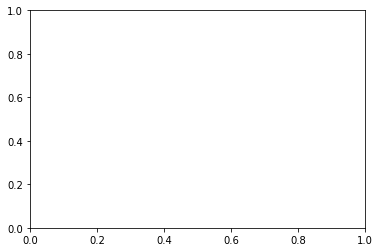

In [112]:
plot_row(x_test_df.iloc[1500])

In [ ]:
plot_row(df_test[df_test['hash'] == '726ca607cd4197a8e33eafc8de6862bf_23'])

In [ ]:
new_train = pd.read_csv("data_avg.csv")
new_test = pd.read_csv("data_test_avg.csv")

In [ ]:
new_train_df = new_train.groupby('hash')
new_train_df_list = list(new_train_df)
new_test_df = new_test.groupby('hash')
new_test_df_list = list(new_test_df)

In [ ]:
train_dataset_1 = []
print(len(new_train_df_list))
for index, sample in enumerate(new_train_df_list):
    features = {}
    features['hash'] = sample[0]
    for index1, row in sample[1].iterrows():
        features['avg_trip_duration_'+ str(row['entry_hour'])]  = features.get('avg_trip_duration_'+ str(row['entry_hour']),0) + row['avg_trip_duration']
        features['avg_trip_length_'+ str(row['entry_hour'])]  = features.get('avg_trip_length_'+ str(row['entry_hour']),0) + row['avg_trip_length']
        features['avg_azimuth_'+ str(row['entry_hour'])]  = features.get('avg_azimuth_'+ str(row['entry_hour']),0) + row['avg_azimuth']
    features['box_area'] = sample[1].box_area.mean()
    train_dataset_1.append(features)
    if index % 10000 == 0:
        print(index)

In [ ]:
test_dataset_1 = []
print(len(new_test_df_list))
for index, sample in enumerate(new_test_df_list):
    features = {}
    features['hash'] = sample[0]
    for index1, row in sample[1].iterrows():
        features['avg_trip_duration_'+ str(row['entry_hour'])]  = features.get('avg_trip_duration_'+ str(row['entry_hour']),0) + row['avg_trip_duration']
        features['avg_trip_length_'+ str(row['entry_hour'])]  = features.get('avg_trip_length_'+ str(row['entry_hour']),0) + row['avg_trip_length']
        features['avg_azimuth_'+ str(row['entry_hour'])]  = features.get('avg_azimuth_'+ str(row['entry_hour']),0) + row['avg_azimuth']
#     features['avg_azimuth'] = sample[1].avg_azimuth.mean()
    features['box_area'] = sample[1].box_area.mean()
    test_dataset_1.append(features)
    if index % 10000 == 0:
        print(index)

In [ ]:
x_train_df_1 = pd.DataFrame(train_dataset_1).fillna(0)
x_test_df_1 = pd.DataFrame(test_dataset_1).fillna(0)

In [ ]:
x_train_df_1 = x_train_df_1.sort_values('hash',ascending=True)
x_test_df_1 = x_test_df_1.sort_values('hash',ascending=True)

In [ ]:
print(x_train_df.shape, x_test_df.shape)

In [ ]:
x_train_df_1.to_pickle('new_x_train_df')
x_test_df_1.drop(['avg_azimuth'], axis=1).to_pickle('new_x_test_df')

# Unused

In [ ]:
# pca = decomposition.PCA()
# pca.fit(x_1)
# plt.figure(1, figsize=(4, 3))
# plt.clf()
# plt.axes([.2, .2, .7, .7])
# plt.plot(pca.explained_variance_, linewidth=2)
# plt.axis('tight')
# plt.xlabel('n_components')
# plt.ylabel('explained_variance_')
# x_1 = pca.transform(x_1)